In [1]:
import cartopy.crs as ccrs
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import pyproj
from pyproj import Transformer
from datetime import datetime, timedelta
import os, fnmatch, glob
import cmocean 
import rasterio
from rasterio.plot import show
import sys
sys.path.append('/home/maltem/miniforge3/envs/opendrift/lib/python3.11/site-packages')
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.windblow import WindBlow
import geopy.distance

/home/maltem/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    #print(x)
    x=int(x[0])
    y=int(y[0])
    
    return (x,y)

def findindex_reg(alat,alon,plat,plon):

    x=np.argmin(np.abs(alon-plon))
    y=np.argmin(np.abs(alat-plat))
    return(x,y)


In [3]:
class Model_Trajectory:
    
    def __init__(self, modeltraj,modeleval,lat,lon,initime,no_seeds,radius_seeds):
        self.modeltraj = modeltraj
        self.modeleval = modeleval
        self.seedlat = lat
        self.seedlon = lon
        self.initime = initime
        self.no_seeds = no_seeds
        self.radius_seeds = radius_seeds
        
    def info(self):
        print ('Windtrajectory from ', self.modeltraj, "forecast evaluation of " ,self.modeleval)
        print ('Lon: ',self.seedlon); print ('Lat: ',self.seedlat); print ('Initial time: ',self.initime)

    # Produce winddrift trajectories        
    def makeWinddrift(self):
    
        o = WindBlow(loglevel=20)  
        self.traj_file = 'tmp_transfer.nc'
        
        if self.modeltraj=='MET-AROME':
        
            year = datetime.strftime(self.initime, '%Y')
            month = datetime.strftime(self.initime, '%m')
            day = datetime.strftime(self.initime, '%d')
        
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/'
            fc_data_path=fc_data_path + year +"/"+ month  +"/"+ day+"/" 
            fc_file = fc_data_path + 'arome_arctic_det_2_5km_'+year+month+day+'T00Z.nc'

            reader_arome = reader_netCDF_CF_generic.Reader(fc_file)
            o.add_reader([reader_arome])
            o.seed_elements(self.seedlon, self.seedlat, radius=self.radius_seeds, number=self.no_seeds, time=reader_arome.start_time)
            o.run(steps=4*48, time_step=900, time_step_output=3600, outfile=self.traj_file)
 
    # Evaluate forecasts along calculated trajectories    
    def getModelTrajectoryForecast(self,leadtime,maxleadtime): # leadtime given in days
    
        inDomain=True
    
        # Retrieve the trajectory data from opendrift outputfile: 
        # --
        WindTraj = xr.open_mfdataset(self.traj_file)
        ttime = WindTraj.time
        tlat  = np.squeeze(np.array(WindTraj.lat))
        tlon  = np.squeeze(np.array(WindTraj.lon))
        tray  = np.squeeze(np.array(WindTraj.trajectory))
        print('Model ',self.modeleval); print('Number of trajectories',len(tray)); print('Number of time steps',len(tlat[0,:]))
    
        t2m=np.zeros((len(tray),len(tlat[0,:])));  sic=np.zeros((len(tray),len(tlat[0,:])))
        ts= np.zeros((len(tray),len(tlat[0,:])));  ts_obs= np.zeros((len(tray),len(tlat[0,:])))
        lat=np.zeros((len(tray),len(tlat[0,:])));  lon=np.zeros((len(tray),len(tlat[0,:])))
    
        WindTraj.close()
        
        evalinittime=self.initime+timedelta(days=-1.*leadtime)
        
        year = datetime.strftime(evalinittime, '%Y')
        month = datetime.strftime(evalinittime, '%m')
        day = datetime.strftime(evalinittime, '%d')

        if self.modeleval=='ECCC-HRDPSN': # Check whether sic comes from RIOPS ?
                                          # Tair has two dimensions, we use [1] now ?
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECCC-HRDPSN/'
                                             
            fc_file = fc_data_path +  year+month+day+'00.nc.000002'
            fc = xr.open_dataset(fc_file);
            
            [imax,jmax] = np.shape(fc['nav_lat'])
        
            for ens in range(len(tray)):        
                for i in range(len(tlat[0,:])):
                    [ix,jx] = findindex(fc['nav_lat'],fc['nav_lon'],tlat[ens,i],tlon[ens,i]) 
                    if (ix==0 or jx == 0 or ix==imax or jx==jmax):
                        inDomain = False
                        #print ('Out of Domain',i)
                    else:
                        inDomain= True      
                        
                    currentleadtime=int((ttime[i]-np.datetime64(evalinittime,'s'))/3600/1000000000)
                    
                    if (currentleadtime>maxleadtime):
                        inDomain = False    
                        
                    if (inDomain):      
                        fctime = fc.sel(time_counter=ttime[i],method='nearest')
                        t2m_nc = fctime['Tair'].isel(z=1, y=ix, x=jx)
                        sic[ens,i]=np.nan
                        t2m[ens,i]=float(t2m_nc.values)+273.15
                        ts[ens,i]=np.nan
                        lat[ens,i]=float(tlat[ens,i])
                        lon[ens,i]=float(tlon[ens,i]) 
                    else:
                        t2m[ens,i]=np.nan
                        lat[ens,i]=np.nan
                        ts[ens,i]=np.nan
                        lon[ens,i]=np.nan
            fc.close()
            
        
        if self.modeleval=='DWD-ICON':
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/DWD-ICON/'
                  
            fc_file1 = fc_data_path + 'icon_global_'+year+month+day+'00_T_2M.nc'
            fc_file2 = fc_data_path + 'icon_global_'+year+month+day+'00_FR_ICE.nc'
            fc_file3 = fc_data_path + 'icon_global_'+year+month+day+'00_T_ICE.nc'
            fc1 = xr.open_dataset(fc_file1); fc2 = xr.open_dataset(fc_file2); 
            fc3 = xr.open_dataset(fc_file3)
            
            for ens in range(len(tray)):        
                for i in range(len(tlat[0,:])):    
                    
                    currentleadtime=int((ttime[i]-np.datetime64(evalinittime,'s'))/3600/1000000000)
                    
                    if (currentleadtime>maxleadtime):
                        inDomain = False    
                    else:
                        inDomain = True
                    
                    if (inDomain):
                        t2m[ens,i] = fc1['2t'].sel(time=ttime[i],lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                        sic[ens,i] = fc2['ci'].sel(time=ttime[i],lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                        ts[ens,i]  = fc3['ist'].sel(time=ttime[i],lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                        lat[ens,i]=float(tlat[ens,i])
                        lon[ens,i]=float(tlon[ens,i])
                    else:
                        t2m[ens,i] = np.nan
                        sic[ens,i] = np.nan
                        ts[ens,i]  = np.nan
                        lat[ens,i]=np.nan
                        lon[ens,i]=np.nan
                        
            fc1.close(); fc2.close(); fc3.close()
        
        if self.modeleval=='ECMWF-IFS':
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECMWF-IFS/'
            fc_file = fc_data_path + 'Arctic.ECMWF_extracted_'+year+month+day+'T00Z.nc'
            fc = xr.open_dataset(fc_file)
                    
            for ens in range(len(tray)):        
                for i in range(len(tlat[0,:])):    
                    
                    currentleadtime=int((ttime[i]-np.datetime64(evalinittime,'s'))/3600/1000000000)
                    
                    if (currentleadtime>maxleadtime):
                        inDomain = False    
                    else:
                        inDomain = True
                    
                    if (inDomain):
                        t2m[ens,i] = fc['T2M'].sel(time=ttime[i],lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                        sic[ens,i] = fc['CI'].sel(time=ttime[i],lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                        ts[ens,i]  = fc['SKT'].sel(time=ttime[i],lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                        lat[ens,i]=float(tlat[ens,i])
                        lon[ens,i]=float(tlon[ens,i])
                    else:
                        t2m[ens,i] = np.nan
                        sic[ens,i] = np.nan
                        ts[ens,i]  = np.nan
                        lat[ens,i]=np.nan
                        lon[ens,i]=np.nan                  
                        
            fc.close()
            
        if self.modeleval=='ECMWF-AIFS':
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECMWF-AIFS/'                          
            fc_file = fc_data_path + 'Arctic.ECMWF_AIFS_extracted_'+year+month+day+'T00Z.nc'
            fc = xr.open_dataset(fc_file)
            
            for ens in range(len(tray)):        
                for i in range(len(tlat[0,:])):        
                    
                    currentleadtime=int((ttime[i]-np.datetime64(evalinittime,'s'))/3600/1000000000)
                    
                    if (currentleadtime>maxleadtime):
                        inDomain = False    
                    else:
                        inDomain = True
                    
                    if (inDomain):
                        t2m[ens,i] = fc['2t'].sel(time=ttime[i],lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                        ts[ens,i]  = fc['skt'].sel(time=ttime[i],lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                        sic[ens,i] = np.nan
                        lat[ens,i]=float(tlat[ens,i])
                        lon[ens,i]=float(tlon[ens,i])
                    else:
                        t2m[ens,i] = np.nan
                        sic[ens,i] = np.nan
                        ts[ens,i]  = np.nan
                        lat[ens,i]=np.nan
                        lon[ens,i]=np.nan                  
                                            
            fc.close()
        
        if self.modeleval=='MF-AROME':
        
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MF-AROME/merged/'
                                      
            fc_file = fc_data_path + 'AROME_SVALBARD_'+year+month+day+'0000.nc'  
            fcref_file = '/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MF-AROME/AROME_SVALBARD_202404161200_202404161600.nc'
            
            fc = xr.open_dataset(fc_file)
            fcref = xr.open_dataset(fcref_file)
            
            [imax,jmax] = np.shape(fcref['Latitude'])
            print 
            for ens in range(len(tray)):          
                for i in range(len(tlat[0,:])):
                    [ix,jx] = findindex(fcref['Latitude'],fcref['Longitude'],tlat[ens,i],tlon[ens,i]) 
                    if (ix==0 or jx == 0 or ix==imax or jx==jmax):
                        inDomain = False
                        #print ('Out of Domain',i)
                    else:
                        inDomain= True
                    currentleadtime=int((ttime[i]-np.datetime64(evalinittime,'s'))/3600/1000000000)
                    if (currentleadtime>maxleadtime):
                        inDomain = False
                    if (inDomain):      
                        fctime = fc.sel(time=ttime[i],method='nearest')
                        t2m_nc = fctime['T_2M'].isel(lat=ix, lon=jx)
                        ts_nc  = fctime['TS'].isel(lat=ix, lon=jx)
                        sic[ens,i]=float(fctime['F_ICE'].isel(lat=ix, lon=jx))
                        t2m[ens,i]=float(t2m_nc.values)
                        ts[ens,i] =float(ts_nc.values)
                        lat[ens,i]=float(tlat[ens,i])
                        lon[ens,i]=float(tlon[ens,i]) 
                    else:
                        t2m[ens,i]=np.nan
                        sic[ens,i]=np.nan
                        ts[ens,i]  = np.nan
                        lat[ens,i]=np.nan
                        lon[ens,i]=np.nan
            fc.close()
            
        if self.modeleval=='MF-ARPEGE':
            
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MF-ARPEGE/merged/'
            
            fc_file = fc_data_path + 'ARPEGE_SVALBARD_'+year+month+day+'0000.nc'  
            fc = xr.open_dataset(fc_file)
    
    
        if self.modeleval=='MET-AROME':
            
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/'
            fc_data_path=fc_data_path + year +"/"+ month  +"/"+ day+"/" 
            fc_file = fc_data_path + 'arome_arctic_det_2_5km_'+year+month+day+'T00Z.nc'      
            fc = xr.open_dataset(fc_file)
            # add modis because they are on the same grid:
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/observations/remotesensing/'
            fc_file1 = fc_data_path+'aa-modis-2024.nc'
            fc1 = xr.open_dataset(fc_file1)
                      
            [imax,jmax] = np.shape(fc['latitude'])
            print 
            for ens in range(len(tray)):          
                for i in range(len(tlat[0,:])):
                    [ix,jx] = findindex(fc['latitude'],fc['longitude'],tlat[ens,i],tlon[ens,i]) 
                    
                    if (ix==0 or jx == 0 or ix==imax or jx==jmax):
                        inDomain = False
                        #print ('Out of Domain',i)
                    else:
                        inDomain= True
                    currentleadtime=int((ttime[i]-np.datetime64(evalinittime,'s'))/3600/1000000000)
                    if (currentleadtime>maxleadtime):
                        inDomain = False
                    if (inDomain):      
                        fctime = fc.sel(time=ttime[i],method='nearest')
                        t2m_nc = fctime['air_temperature_2m'].isel(y=ix, x=jx)
                        sic[ens,i]=float(fctime['SFX_SIC'].isel(y=ix, x=jx))
                        ts[ens,i]=float(fctime['SFX_TS'].isel(y=ix, x=jx))
                        t2m[ens,i]=float(t2m_nc.values)
                        #MODIS                
                        fctime = fc1.sel(time=ttime[i],method='nearest')
                        ts_nc = fctime['modis_sist'].isel(y=ix, x=jx)
                        ts_obs[ens,i]=float(ts_nc.values)                
                        lat[ens,i]=float(tlat[ens,i])
                        lon[ens,i]=float(tlon[ens,i]) 
                    else:
                        t2m[ens,i]=np.nan
                        sic[ens,i]=np.nan
                        ts[ens,i]=np.nan
                        ts_obs[ens,i]=np.nan                
                        lat[ens,i]=np.nan
                        lon[ens,i]=np.nan
                                        
            self.ts_obs=np.array(ts_obs)                            
            fc.close();fc1.close()
    
        self.time = WindTraj.time
        self.lat  = lat
        self.lon  = lon
        self.t2m  = np.array(t2m)
        self.ts   = np.array(ts)
        self.sic  = np.array(sic)
            
    def getBuoyCollocations(self,leadno):
            
        ensno  = len(self.lat[:,0])
        t2m_buoys=np.zeros((ensno,leadno)); t2m_buoys=t2m_buoys*np.nan
        
        #Load OMB data
        OMBraw = xr.open_mfdataset('/home/maltem/work/python/data/SvalMIZ2024/cruise/2024_KVS_deployment.nc')        
        
        # Loop over all trajectories and find observations close-by
        for ti in range(leadno): # Only the first leadno hours of the forecast
            timenow=self.time[ti]     
            for ens in range(len(self.lat[:,0])):
                timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10
                for buoy_no in range(np.min(np.shape(timemask))):
                    tb = np.where(timemask[buoy_no,:])
                    tb=np.squeeze(tb)
                    #print (tb)
                    #print(np.any(tb))
                    #print(type(tb))
                    if(np.size(tb)>1):#  TODO here we only take the first one
                        tb=tb[0]
                        
                    if tb:
                        
                        #for bb in range(np.shape(tb)[1]):
                        for bb in range(1):  # TODO here we only take the first one
                        
                            # Buoy Coordinates
                                latb = np.array(OMBraw.lat[buoy_no,np.array(tb)])
                                lonb = np.array(OMBraw.lon[buoy_no,np.array(tb)])
                                # Trajectory Coordinates / ensemblermember&time - dependent
                                # lon[ens,ti];lat[ens,ti]
                
                                coords_1 = (latb, lonb)
                                coords_2 = (self.lat[ens,ti],self.lon[ens,ti])
                                if ~np.isnan(coords_2)[0]:
                                    if geopy.distance.geodesic(coords_1, coords_2).km < 5: 
                                        t2m_buoys[ens,ti] = np.array(OMBraw.temp_1m_calibrated[buoy_no,np.array(tb)])
        
        
        
        self.t2m_buoys=t2m_buoys
    
                        
    def plot_forecasts(self,leadno):
        fig, ax = plt.subplots(figsize=(8, 4),nrows=2,ncols=1)
        for ens in range(len(self.lat[:,0])):
            ax[1].plot(self.time[0:leadno],self.sic[ens,0:leadno],marker='.',linewidth=0.2,color='k')
            ax[0].plot(self.time[0:leadno],self.t2m[ens,0:leadno]-273.15,linewidth=0.2,color='k'),
            
            
            ax[0].scatter(self.time[0:leadno],self.t2m_buoys[ens,:],marker='*',s=10,color='r')
            ax[0].scatter(self.time[0:leadno],self.t2m_buoys[ens,:],marker='o',s=10,color='r')
            
            

In [4]:
if (True):
    latseed = 79.94
    lonseed = 17.7
    no_ens  = 20     # Number of ensembles in windblow transjectory
    spread_ens = 2500
    # Initialization date:
    date = datetime.strptime('2024-04-12 00:00:00','%Y-%m-%d %H:%M:%S') 
if (True):
    latseed = 80.95
    lonseed = 15
    no_ens  = 20     # Number of ensembles in windblow transjectory
    spread_ens = 2500
    # Initialization date:
    date = datetime.strptime('2024-04-15 00:00:00','%Y-%m-%d %H:%M:%S') 
if (False):   
    latseed = 80.7
    latseed = 80.6
    lonseed = 17.7
    lonseed = 18
    no_ens  = 20     # Number of ensembles in windblow transjectory
    spread_ens = 3500
    # Initialization date:
    date = datetime.strptime('2024-04-14 00:00:00','%Y-%m-%d %H:%M:%S') 

if (True):   
    latseed = 79.9
    lonseed = 11.9
    no_ens  = 20     # Number of ensembles in windblow transjectory
    spread_ens = 3500
    # Initialization date:
    date = datetime.strptime('2024-04-20 00:00:00','%Y-%m-%d %H:%M:%S') 

    
    
    
m1 = Model_Trajectory('MET-AROME','MET-AROME',latseed,lonseed,date,no_ens,spread_ens)

m1.info()
m1.makeWinddrift()                 # Produce wind drift trajectories
m1.getModelTrajectoryForecast(0,66)# Co-locate forecast model
m1.getBuoyCollocations(24)         # Find co-located buoylocations
#m1.plot_forecasts(24)              # Plot the individual forecast

Windtrajectory from  MET-AROME forecast evaluation of  MET-AROME
Lon:  11.9
Lat:  79.9
Initial time:  2024-04-20 00:00:00


17:31:20 INFO    opendrift.models.basemodel:515: OpenDriftSimulation initialised (version 1.11.13 / v1.11.13-11-gfa23a9f)
17:31:20 INFO    opendrift.readers.reader_netCDF_CF_generic:102: Opening dataset: /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc
17:31:24 INFO    opendrift.readers.reader_netCDF_CF_generic:314: Detected dimensions: {'time': 'time', 'x': 'x', 'y': 'y'}
16:31:24 INFO    opendrift.models.basemodel:2038: 2024-04-20 00:00:00 - step 1 of 192 - 20 active elements (0 deactivated)
16:31:24 INFO    opendrift.models.basemodel:2038: 2024-04-20 00:15:00 - step 2 of 192 - 20 active elements (0 deactivated)
16:31:25 INFO    opendrift.models.basemodel:2038: 2024-04-20 00:30:00 - step 3 of 192 - 20 active elements (0 deactivated)
16:31:25 INFO    opendrift.models.basemodel:2038: 2024-04-20 00:45:00 - step 4 of 192 - 20 active elements (0 deactivated)
16:31:25 INFO    opendrift.models.basemodel:2

16:31:28 WARNING opendrift.readers.basereader.structured:324: Data block from /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc not large enough to cover element positions within timestep. Buffer size (20) must be increased. See `Variables.set_buffer_size`.
16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-20 10:45:00 - step 44 of 192 - 20 active elements (0 deactivated)
16:31:28 WARNING opendrift.readers.basereader.structured:324: Data block from /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc not large enough to cover element positions within timestep. Buffer size (20) must be increased. See `Variables.set_buffer_size`.
16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-20 11:00:00 - step 45 of 192 - 20 active elements (0 deactivated)
16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-20 11:

16:31:28 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-20 17:30:00 - step 71 of 192 - 20 active elements (0 deactivated)
16:31:28 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-20 17:45:00 - step 72 of 192 - 20 active elements (0 deactivated)
16:31:28 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIEN

16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-20 22:15:00 - step 90 of 192 - 20 active elements (0 deactivated)
16:31:28 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-20 22:30:00 - step 91 of 192 - 20 active elements (0 deactivated)
16:31:28 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-20 22:45:00 - step 92 of 192 - 20 active elements (0 deactivated)
16:31:28 INFO    opendrift.models.base

16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-21 03:15:00 - step 110 of 192 - 20 active elements (0 deactivated)
16:31:28 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-21 03:30:00 - step 111 of 192 - 20 active elements (0 deactivated)
16:31:28 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:28 INFO    opendrift.models.basemodel:2038: 2024-04-21 03:45:00 - step 112 of 192 - 20 active elements (0 deactivated)
16:31:28 INFO    opendrift.models.b

16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 08:15:00 - step 130 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 08:30:00 - step 131 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 08:45:00 - step 132 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.b

16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 13:15:00 - step 150 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 13:30:00 - step 151 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 13:45:00 - step 152 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.b

16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 18:15:00 - step 170 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 18:30:00 - step 171 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 18:45:00 - step 172 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.b

16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 23:15:00 - step 190 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 23:30:00 - step 191 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.basemodel.environment:648: All 20 particles (-6.23--4.80E, 82.45-82.86N) are outside domain of /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/20/arome_arctic_det_2_5km_20240420T00Z.nc (-17.96-79.55E, 62.13-87.57N)
16:31:29 INFO    opendrift.models.basemodel:2038: 2024-04-21 23:45:00 - step 192 of 192 - 20 active elements (0 deactivated)
16:31:29 INFO    opendrift.models.b

Model  MET-AROME
Number of trajectories 20
Number of time steps 49


In [5]:
leadday = 1

m1.getModelTrajectoryForecast(leadday,66)  


m2 = Model_Trajectory('MET-AROME','ECMWF-IFS',latseed,lonseed,date,no_ens,2500)
m2.info()
m2.traj_file = 'tmp_transfer.nc'
#m2.makeWinddrift()
m2.getModelTrajectoryForecast(leadday,72)
#m2.getBuoyCollocations(24)
#m2.plot_forecasts(24)


m3 = Model_Trajectory('MET-AROME','ECMWF-AIFS',latseed,lonseed,date,no_ens,2500)
m3.info()
m3.traj_file = 'tmp_transfer.nc'
#m2.makeWinddrift()
m3.getModelTrajectoryForecast(leadday,72)
#m3.getBuoyCollocations(24)
#m3.plot_forecasts(24)

m4 = Model_Trajectory('MET-AROME','ECCC-HRDPSN',latseed,lonseed,date,no_ens,2500)
m4.info()
m4.traj_file = 'tmp_transfer.nc'
#m2.makeWinddrift()
m4.getModelTrajectoryForecast(leadday,48)
#m4.getBuoyCollocations(24)
#m4.plot_forecasts(24)

m5 = Model_Trajectory('MET-AROME','DWD-ICON',latseed,lonseed,date,no_ens,2500)
m5.info()
m5.traj_file = 'tmp_transfer.nc'
#m2.makeWinddrift()
m5.getModelTrajectoryForecast(leadday,72)
#m5.getBuoyCollocations(24)
#m5.plot_forecasts(24)

m6 = Model_Trajectory('MET-AROME','MF-AROME',latseed,lonseed,date,no_ens,2500)
m6.info()
m6.traj_file = 'tmp_transfer.nc'
#m2.makeWinddrift()
m6.getModelTrajectoryForecast(leadday,48)
#m6.getBuoyCollocations(24)
#m6.plot_forecasts(24)


Model  MET-AROME
Number of trajectories 20
Number of time steps 49
Windtrajectory from  MET-AROME forecast evaluation of  ECMWF-IFS
Lon:  11.9
Lat:  79.9
Initial time:  2024-04-20 00:00:00
Model  ECMWF-IFS
Number of trajectories 20
Number of time steps 49
Windtrajectory from  MET-AROME forecast evaluation of  ECMWF-AIFS
Lon:  11.9
Lat:  79.9
Initial time:  2024-04-20 00:00:00
Model  ECMWF-AIFS
Number of trajectories 20
Number of time steps 49
Windtrajectory from  MET-AROME forecast evaluation of  ECCC-HRDPSN
Lon:  11.9
Lat:  79.9
Initial time:  2024-04-20 00:00:00
Model  ECCC-HRDPSN
Number of trajectories 20
Number of time steps 49
Windtrajectory from  MET-AROME forecast evaluation of  DWD-ICON
Lon:  11.9
Lat:  79.9
Initial time:  2024-04-20 00:00:00
Model  DWD-ICON
Number of trajectories 20
Number of time steps 49
Windtrajectory from  MET-AROME forecast evaluation of  MF-AROME
Lon:  11.9
Lat:  79.9
Initial time:  2024-04-20 00:00:00
Model  MF-AROME
Number of trajectories 20
Number of 

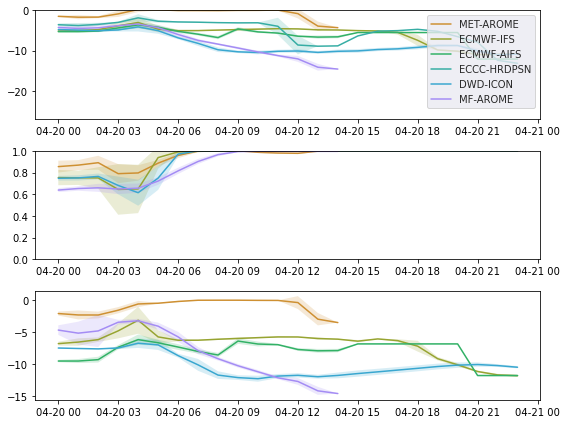

In [6]:
leadno=24

fig, ax = plt.subplots(figsize=(8, 6),nrows=3,ncols=1)
clrs = sns.color_palette("husl", 8)
with sns.axes_style("darkgrid"):
    
    for models in range(1,7):
        if models==1:
            mm=m1 
        elif models==2:
            mm=m2
        elif models==3:
            mm=m3
        elif models==4:
            mm=m4
        elif models==5:
            mm=m5
        elif models==6:
            mm=m6    
        meanst = np.nanmean(mm.t2m,axis=0)-273.15; sdt = np.nanstd(mm.t2m,axis=0)
        ax[0].plot(mm.time[0:leadno], meanst[0:leadno], label=mm.modeleval, c=clrs[models])
        ax[0].fill_between(mm.time[0:leadno], meanst[0:leadno]-sdt[0:leadno], meanst[0:leadno]+sdt[0:leadno] ,alpha=0.2, facecolor=clrs[models])
        
        meanst = np.nanmean(mm.sic,axis=0); sdt = np.nanstd(mm.sic,axis=0)
        ax[1].plot(mm.time[0:leadno], meanst[0:leadno], label=mm.modeleval, c=clrs[models])
        ax[1].fill_between(mm.time[0:leadno], meanst[0:leadno]-sdt[0:leadno], meanst[0:leadno]+sdt[0:leadno] ,alpha=0.2, facecolor=clrs[models])
    
        meanst = np.nanmean(mm.ts,axis=0)-273.15; sdt = np.nanstd(mm.ts,axis=0)
        ax[2].plot(mm.time[0:leadno], meanst[0:leadno], label=mm.modeleval, c=clrs[models])
        ax[2].fill_between(mm.time[0:leadno], meanst[0:leadno]-sdt[0:leadno], meanst[0:leadno]+sdt[0:leadno] ,alpha=0.2, facecolor=clrs[models])
        
    meanst = np.nanmean(m1.ts_obs,axis=0)-273.15; sdt = np.nanstd(m1.ts_obs,axis=0)
    ax[2].plot(m1.time[0:leadno], meanst[0:leadno], label='MODIS', c=clrs[7])
    ax[2].fill_between(m1.time[0:leadno], meanst[0:leadno]-sdt[0:leadno], meanst[0:leadno]+sdt[0:leadno] ,alpha=0.2, facecolor=clrs[7])
        
       
    
    for ens in range(len(mm.lat[:,0])):    
        ax[0].scatter(m1.time[0:leadno],m1.t2m_buoys[ens,:],marker='*',s=10,color='r')
        ax[0].scatter(m1.time[0:leadno],m1.t2m_buoys[ens,:],marker='o',s=10,color='r')
        
    ax[1].set_ylim([0., 1])    
    ax[0].set_ylim([-27, 0])    
    ax[0].legend()
   

EPSG:3413


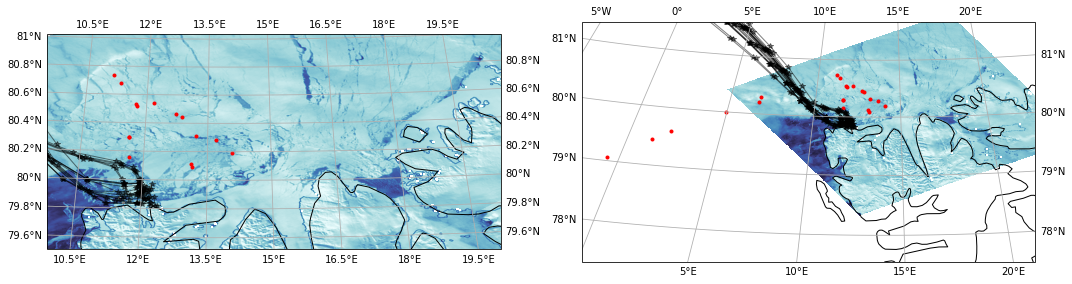

In [7]:
leadno=24
# Load visible MODIS satellite image
datetime_str = datetime.strftime(date, '%Y-%m-%d')
#geotiff_path = '/home/maltem/work/python/data/SvalMIZ2024/SatellitePictures/snapshot-'+datetime_str+'T00_00_00Z.tif'
geotiff_path = '/home/maltem/work/python/data/SvalMIZ2024/SatellitePictures/snapshot-2024-04-11T00_00_00Z.tif'
with rasterio.open(geotiff_path, 'r') as src:
    raster_crs = src.crs
    print(raster_crs)
    left, bottom, right, top = src.bounds
    landsat = src.read()[0, :, :]
    landsat = np.ma.masked_where(landsat <= 0,
                                 landsat,
                                 copy=True)
    landsat = (landsat - np.min(landsat)) / (np.max(landsat) - np.min(landsat))        
# Load SeaIce             -----------------------------------#
dir_seaiceproduct_hres= '/lustre/storeB/project/fou/hi/oper/barents_eps/archive/obs/'
file_name_stub         = 'barents_icec-obs_%s' #barents_icec-obs_20240415T00Z.nc
datetime_str = datetime.strftime(date, '%Y%m%d')
file_prename = file_name_stub % datetime_str
infile_name = glob.glob(dir_seaiceproduct_hres + file_prename + '*.nc')
if infile_name:
    IceIn = xr.open_mfdataset(infile_name)
    lats = np.array(IceIn['lat'])
    lons = np.array(IceIn['lon'])
    sicn = np.array(IceIn['ice_conc'])
    sicn=np.squeeze(np.where(sicn<0.1,np.nan,sicn))  
    
    
    
#Load OMB data
OMBraw = xr.open_mfdataset('/home/maltem/work/python/data/SvalMIZ2024/cruise/2024_KVS_deployment.nc')       
# Create the projection
plot_proj = ccrs.Orthographic(14,25)

fig, ax = plt.subplots(figsize=(15, 8),nrows=1,ncols=2,
                       subplot_kw={'projection': plot_proj})

ax[0].coastlines(resolution='50m')
ax[1].coastlines(resolution='50m')
ax[0].set_extent([10, 20, 79.5, 81], crs=ccrs.PlateCarree())
ax[1].set_extent([0, 21, 77.5, 81.5], crs=ccrs.PlateCarree())

# -- Subplot - 1- #
#    MODIS visible satellite picture
contour3 = ax[0].imshow(landsat, transform=ccrs.epsg(3413),cmap=cmocean.cm.ice,extent=(left, right, bottom, top))
contour3 = ax[1].imshow(landsat, transform=ccrs.epsg(3413),cmap=cmocean.cm.ice,extent=(left, right, bottom, top))

# -- Subplot - 2- #
#    AMSR2 sea-ice contour
#contour1 = ax[1].contourf(lons, lats, sicn, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice,alpha=0.4)

# 
startdate = date
timesteps_to_loop=1

for dt in range(timesteps_to_loop): #MAKE LOOP
    date = startdate + timedelta(hours=dt*1)
    #------------------------------------------------------------#
    #Find all buoys at date times closer than 29 minutes
    timenow = np.datetime64(date)
    timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10

    for buoy_no in range(np.min(np.shape(timemask))):
        tb = np.where(timemask[buoy_no,:]); #tb = [x[0] for x in tb1]
        if tb:
            ax[0].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())
            ax[1].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())            
            
WindTraj = xr.open_mfdataset('tmp_transfer.nc')
ttime = WindTraj.time
tlat  = np.squeeze(np.array(WindTraj.lat))
tlon  = np.squeeze(np.array(WindTraj.lon))
tray  = np.squeeze(np.array(WindTraj.trajectory))
   
t2m=np.zeros((len(tray),len(tlat[0,:])));  sic=np.zeros((len(tray),len(tlat[0,:])))
lat=np.zeros((len(tray),len(tlat[0,:])));  lon=np.zeros((len(tray),len(tlat[0,:])))
    
WindTraj.close()


# Loop over all trajectories and plot:  
for ens in range(len(tlat[:,0])):         
    ax[0].plot(list(np.squeeze(tlon[ens,0:leadno])),list(np.squeeze(tlat[ens,0:leadno])),'-',marker='*',linewidth=1,color='k',transform = ccrs.PlateCarree(),alpha=0.5)
    ax[1].plot(tlon[ens,0:leadno],tlat[ens,0:leadno],'-',marker='*',linewidth=1,color='k',transform = ccrs.PlateCarree(),alpha=0.5)
    
    
ax[0].gridlines(draw_labels=True)    
ax[1].gridlines(draw_labels=True)

plt.show()
OMBraw.close()
